In [5]:
from coffea import hist
import math
from time import process_time
import os
import psutil
import uproot
import awkward as ak
from sklearn.neighbors import KernelDensity
from scipy.stats import moyal
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import metrics
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
plt.style.use(hep.style.CMS)

from matplotlib import colors
POPTS={'norm':colors.LogNorm(vmin=1,vmax=200)}

In [2]:
SimParticle_attrs = ['pdgID','trkID','mass','e','kine','vx','vy','vz','endx','endy','endz','px','py','pz']
RecoilSimHit_attrs = ['x', 'y', 'z', 'px', 'py', 'pz', 'pdgid', 'edep', 'pathLength', 'layer']
EcalSimHit_attrs = ['edep', 't', 'x', 'y', 'z', 'layer']
EcalRecHit_attrs = ['amp', 'e', 't', 'x', 'y', 'z', 'layer']


branches = {
    "Sim_Particle": SimParticle_attrs,
    "Recoil_SimHit": RecoilSimHit_attrs,
    "Ecal_SimHit": EcalSimHit_attrs,
    "Ecal_RecHit": EcalRecHit_attrs,
    "n": ["Sim_Particle", "Recoil_SimHit", "Ecal_SimHit", "Ecal_RecHit"]
}

def getData(fnames="", treeName="Events", chunks=False):
    branchlist = []
    for collection, attrs in branches.items():
        branchlist += [collection+"_"+attr for attr in attrs]
    if chunks: ldmx_dict = uproot.iterate(fnames+":"+treeName, branchlist)
    else: ldmx_dict = uproot.lazy(fnames+":"+treeName, branchlist)
    return ldmx_dict

#Repackages ldmx_dict into new dictionary of dictionaries of form
#ldmx_events={Sim_particle: {pdgID:___, trkID:___,...}, Ecal_RecHit: {amp:___, e:___, ...}, ...}
def repackage(ldmx_dict):
    evt_dict={}
    for collection in branches:    
        coll_dict={}
        for attr in branches[collection]:
            bname = "{}_{}".format(collection, attr)
            coll_dict[attr] = ldmx_dict[bname]
        evt_dict[collection] = ak.zip(coll_dict)        
    ldmx_events = ak.zip(evt_dict, depth_limit=1)
    return ldmx_events


def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x


#Take the difference between consecutive measurements
def infinitesimalish(arr, lead=0):
    rtn=[]
    for evt in arr:
        evtArr=[]
        prev=evt[0]
        for hit in evt:
            evtArr.append(prev-hit)
            prev=hit
        
        evtArr[0]=lead
        rtn.append(evtArr)
    return ak.Array(rtn)

#Adds angle key:value entry to arr (Usually ldmx_events), using above method and LorentzVector class from coffea
def add_angle(arr):
    part=get_vector(arr)
    arr["theta"] = part.theta*(180/np.pi)
    return 

def add_angle_rTracker(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    },
                    with_name="ThreeVector")
    
    arr["theta"] = part.theta*(180/np.pi)
    
def add_momentum(arr):
    rho = np.sqrt(arr.px**2+arr.py**2+arr.pz**2)
    arr["momentum"] = rho
    return

#Returns ak.Record with coffea.LorentzVector behavior
def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part 
    
def cvBand(arr): 
    if len(arr)==1:
        return 1000
    elif len(arr)<5:
        cross=len(arr)
    else:
        cross=5
        
    bandwidths =np.linspace(0, 2, 100)
    grid = GridSearchCV(KernelDensity(kernel=kernel),
                    {'bandwidth': bandwidths},
                    cv=cross)
    bndwth=grid.fit(arr[:, None])
    best=bndwth.best_params_['bandwidth']
    return best

#best=cvBand(evt.edep)
#if best==1000:
    #match[spot]=evt.edep[0]
    #spot+=1
    #continue
        
def kernelDensity(arr):
    match=np.zeros(ak.num(arr, axis=0))
    spot=0
    for evt in arr:
        if len(evt)==1:
            match[spot]=evt[0]
            spot+=1
            continue
        kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(evt[:, np.newaxis])
        dens = np.exp(kde.score_samples(evt[:, np.newaxis]))
        mostLikely=max(dens)
        for i in range(len(dens)):
            if dens[i]==mostLikely: 
                match[spot]=evt[i]
                break
        spot+=1
    
    return match

In [3]:
#Copying For now so no rerun required
import copy
def cleanData(testData):
    testDataCopy=copy.deepcopy(testData)
    testDataCopyBinary={}

    #------------------Clean Up Data From Dictionary-------------------
    X={}
    true={}
    for coll in testDataCopy:
        for attr in testDataCopy[coll].keys():
            testDataCopy[coll][attr]=ak.Array(ak.fill_none(ak.flatten(testDataCopy[coll][attr], axis=1), -1, axis=-1))

        testDataCopy[coll]=ak.zip(testDataCopy[coll])
        if coll=="Proton":
            testDataCopyBinary[coll]=ak.ones_like(testDataCopy[coll])
        else: 
            testDataCopyBinary[coll]=ak.zeros_like(testDataCopy[coll])


    #---------------Organize X and true---------------------------------
    #First create (n_samples, nfeatures) then merge
    first=True
    for coll in testDataCopy:
        for attr in testDataCopy[coll].fields:
            if first==True:
                X[coll]=testDataCopy[coll][attr][:, np.newaxis]
                true[coll]=testDataCopyBinary[coll][attr]
                first=False
                continue

            X[coll]=ak.concatenate([X[coll], testDataCopy[coll][attr][:, np.newaxis]], axis=1)

        first=True

    #Final Merge
    X=ak.concatenate([X["Proton"], X["Pion"]], axis=0)
    true=ak.concatenate([true["Proton"], true["Pion"]], axis=0)
    
    return np.array(X), np.array(true)

def GenerateAuc(X, true):
    noKineX=X[:,1:]
    clf=HistGradientBoostingClassifier().fit(noKineX, true)
    acc=clf.score(noKineX, true)
    #acc=1
    aucs=[]
    
    for i in np.linspace(100, 1000, 5):
        kineMaskLow=X[:,0]>=i
        kineMaskUpp=X[:,0]<=i+225
        kineMask= kineMaskLow & kineMaskUpp
        bothMask= ak.all(X!=-1, axis=1)
        scores=clf.predict_proba(noKineX[kineMask])
        #scores=noKineX[kineMask]
        aucs.append(metrics.roc_auc_score(true[kineMask], scores[:,1]))
    
    return acc, aucs
    

In [4]:
def ProcessChunk(chunk, mip):
    ldmx_events = repackage(chunk)
    sim_particle = ldmx_events['Sim_Particle']
    recoil_simhit = ldmx_events['Recoil_SimHit']
    ecal_rechit = ldmx_events['Ecal_RecHit']
    
    #Determines if data file is one for protons or pions
    par=""
    ID=0
    restMass=0
    if ak.all(sim_particle.pdgID==2212):
        par="Proton"
        ID=2212
        restMass=938.27208816
    elif ak.all(sim_particle.pdgID==211):
        par="Pion"
        ID=211
        restMass=139.57039
        
    
    recoilEmptyMask=getattr(ldmx_events['n'], "Recoil_SimHit")!=0
    ecalRecEmptyMask=getattr(ldmx_events['n'], "Ecal_RecHit")!=0
    recoil_simhit=recoil_simhit[recoilEmptyMask | ecalRecEmptyMask]
    ecal_rechit=ecal_rechit[recoilEmptyMask | ecalRecEmptyMask]
    
    #pdgID Mask
    recoilIDMask=recoil_simhit.pdgid==ID
    
    twoDMask= recoilIDMask #& recoilMIPMask 
    emptiesIncluded=recoil_simhit[twoDMask]
    #Apply the emptyMask with ak.mask, so that the 1D data alignment is preserved. If you wished to preserve the 
    #2d alignment, you would apply the 2d mask with ak.mask as well. 
    emptiesMask=ak.num(emptiesIncluded)>0 
    noEmpties=ak.mask(emptiesIncluded, emptiesMask)
    
    #Fills Number of Hits
    dropLow=noEmpties[noEmpties.edep>=mip]
    dropLow=ak.mask(dropLow, ak.num(dropLow)>0)
    hits=ak.num(dropLow.edep, axis=1)
    print(hits)
    RecAttrs=ak.zip({"Hits": hits})
    RecAttrs["Kine"]=ak.flatten((sim_particle[recoilEmptyMask | ecalRecEmptyMask]).kine, axis=None)
    
    return par, RecAttrs

    for attr in testData[par].keys():
        if attr[0:3]=="Eca":
            testData[par][attr].append(getattr(EcalAttrs, attr))
        else:
            testData[par][attr].append(getattr(RecAttrs, attr))

def cvRecMIP(fnames, Mips):
    accs=[]
    aucs=[]
    events=[]
                     
    nchunk = 0
    start=process_time()
    for e in Mips:
        ldmx_dict_all = getData(chunks=True, fnames=fnames)
        
        testData={"Proton":{'Kine':[], 'Hits':[]},
                "Pion":  {'Kine':[], 'Hits':[]}}
        
        print('MIP=',e)
        for chunk in ldmx_dict_all:
            par, RecAttrs= ProcessChunk(chunk, e)
            for attr in RecAttrs.fields:
                testData[par][attr].append(RecAttrs[attr])
                
        X, true=cleanData(testData)
        #print(x.layout, tru.layout)
        acc, auc=GenerateAuc(X, true)
        accs.append(acc)
        aucs.append(auc)
        events.append(ak.num(X[X[:,1]!=-1], axis=0))
        
    stop=process_time()
    print("Time to analyze all data is: {}".format((stop-start)/60))
    accs=np.array(accs)
    aucs=np.array(aucs)
    events=np.array(events)
    return accs, aucs, events

    

In [43]:
Mips = np.linspace(0.00, 0.39, 10)
accs, aucs, events= cvRecMIP("data/protonpion_Oct5/*.root", Mips)

MIP= 0.0
[1, 5, 2, 1, 4, 2, 6, 1, 3, 11, 8, 10, ... 9, 2, 1, 1, 1, 1, None, 9, 10, 1, None, 9]
[3, None, 5, 2, None, 7, 1, 1, None, 10, ... None, 3, 2, 2, 2, None, None, 6, 4, 11]
[3, 10, 9, 1, 2, 3, 4, None, 3, 2, 2, 4, ... None, 3, 9, 10, 2, 3, 10, 5, None, 3, 8]
[10, 5, 2, None, 1, 3, 5, 1, 9, 4, 1, 3, ... 2, 5, 10, 10, 2, 1, None, 1, 3, 2, 6, 1]
[3, 1, 1, None, 4, 1, 1, 1, 3, 8, 2, 6, 1, ... 1, 11, 10, 4, 4, 1, 1, 3, 4, 1, 3, 1]
[3, 6, 1, 1, 3, 10, None, None, 3, 1, 2, ... 3, 3, 1, 2, 3, 5, 1, 4, None, None, 2]
MIP= 0.043333333333333335
[1, 5, 2, 1, 4, 2, 6, 1, 3, 10, 8, 10, ... 9, 2, 1, 1, 1, 1, None, 9, 10, 1, None, 9]
[3, None, 4, 2, None, 6, 1, 1, None, 10, ... None, 3, 2, 2, 2, None, None, 6, 4, 10]
[3, 10, 9, 1, 2, 3, 3, None, 3, 2, 2, 4, ... None, 3, 9, 9, 2, 3, 10, 5, None, 3, 8]
[10, 5, 2, None, 1, 3, 5, 1, 9, 4, 1, 3, ... 2, 5, 10, 10, 2, 1, None, 1, 3, 2, 6, 1]
[3, 1, 1, None, 4, 1, 1, 1, 3, 8, 2, 6, 1, ... 1, 11, 10, 4, 4, 1, 1, 3, 4, 1, 3, 1]
[3, 6, 1, 1, 3, 10, None, 

Text(0, 1, 'ROC AUC')

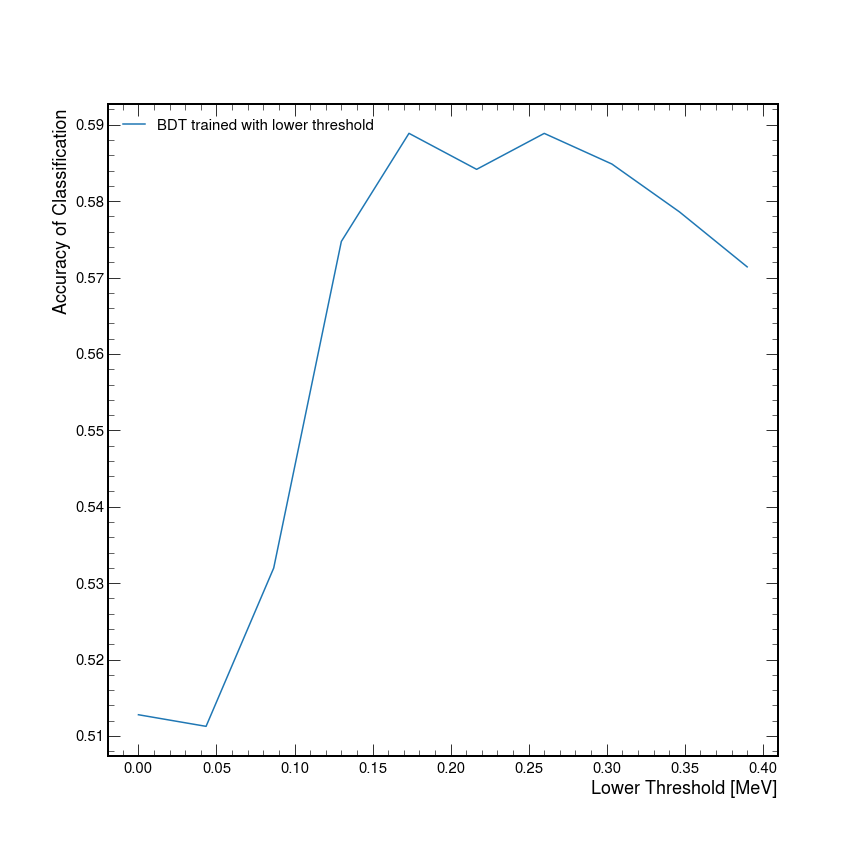

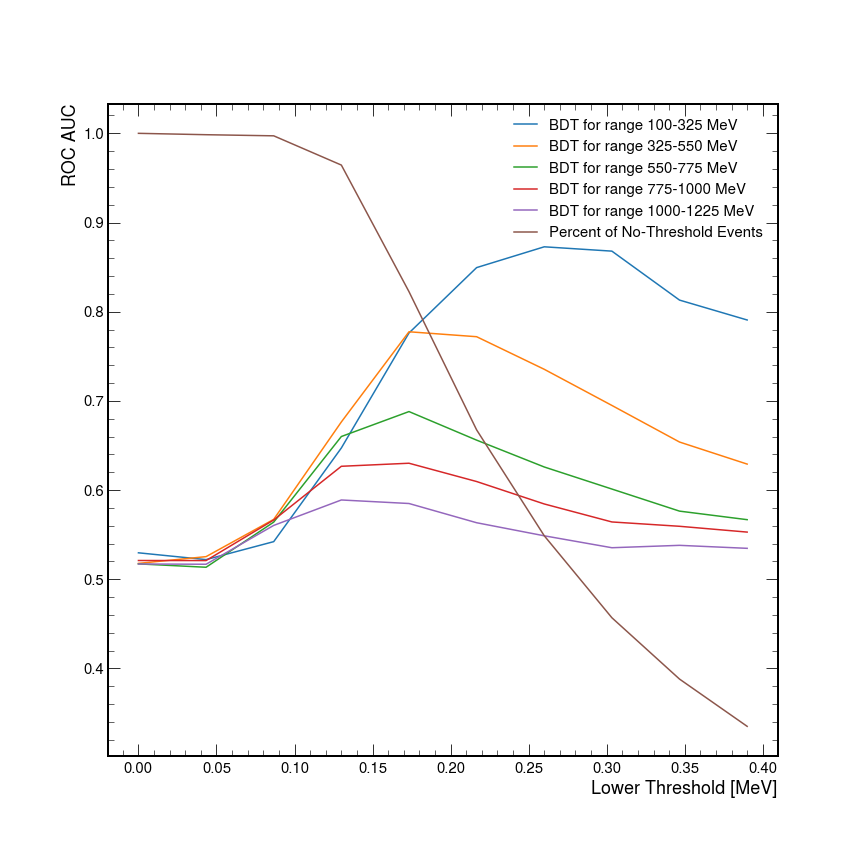

In [41]:
plt.rcParams.update({'font.size': 18})
%matplotlib widget

fig1, ax1=plt.subplots(figsize=(12,12))
ax1.plot(Mips, accs, label="BDT trained with lower threshold")
ax1.legend(loc="upper left")
ax1.set_xlabel("Lower Threshold [MeV]")
ax1.set_ylabel("Accuracy of Classification ")

fig2, ax2=plt.subplots(figsize=(12,12))
for i in range(5):
    ax2.plot(Mips, aucs[:,i], label="BDT for range {}-{} MeV".format(100+i*225,100+(i+1)*225))
ax2.plot(Mips, (events/events[0]), label="Percent of No-Threshold Events")
ax2.legend(loc="upper right")
ax2.set_xlabel("Lower Threshold [MeV]")
ax2.set_ylabel("ROC AUC")
    



In [16]:
x=np.array([[1, 2, 3],[4, 5, 6], [7, 8, 9], [10, 11, 12]])
train, test=np.split(x, 2)
train=[True if i%2==0 else False for i, x in enumerate(x, 1)]
test=[True if i%2==1 else False for i, x in enumerate(x, 1)]
a=x[train]
b=x[test]
print(a)
print(b)

[[ 4  5  6]
 [10 11 12]]
[[1 2 3]
 [7 8 9]]
